In [1]:
import numpy as np

from scipy import ndimage
from scipy import misc
from scipy import linalg
from scipy import argsort
from scipy import signal
from scipy import interpolate
import itertools
import os
import glob

from mpl_toolkits.axes_grid1 import make_axes_locatable

import h5py as h5

from pylab import *

%matplotlib inline
rcParams['figure.figsize'] = 12, 8  # that's default image size for this interactive session
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

import mayavi.mlab as mlab
%load_ext imayavi

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import fibers

# Generate test fibers and planes

In [4]:
def make_fiber_volume(ctrx,ctry,rx,ry, i, angy,angz):
    '''Makes a volume with simulated fibers at positions ctrx,ctry and radii rx,ry.
    i is the size and resolution.  angy and angz are rotations about the y and z axes in radians'''
    [i1,i2,i3] = np.meshgrid(i,i,i, indexing='ij')
    
    #first make an image with the fibers
    I1 = np.zeros((len(i),len(i)), dtype=np.uint16)
    for (ctrx1,ctry1,rx1,ry1) in zip(ctrx,ctry,rx,ry):
        r1 = (((i1[:,:,1]-ctrx1)/rx1)**2 + ((i2[:,:,1]-ctry1)/ry1)**2)
        I1 = I1 + np.exp(-r1)
    
    #then stack it along the z direction
    V = np.tile(I1[:,:,np.newaxis], (1,1,len(i)))
    #and rotate to the appropriate angles
    V = ndimage.interpolation.rotate(V, angy*180/pi, axes=(0,2), reshape=False)
    V = ndimage.interpolation.rotate(V, angz*180/pi, axes=(0,1), reshape=False)
    
    #make the primary axis vector
    ax123 = np.eye(3)
    if np.sum(rx) > np.sum(ry):
        ax123 = ax123[:,[2, 0, 1]]
    else:
        ax123 = ax123[:,[2, 1, 0]]
    
    if angy != 0:
        Ry = np.array([[np.cos(angy), 0, -np.sin(angy)],
                       [0, 1, 0],
                       [np.sin(angy), 0, np.cos(angy)]])
        ax123 = Ry.dot(ax123)

    if angz != 0:
        Rz = np.array([[np.cos(angz), -np.sin(angz), 0],
                       [np.sin(angz), np.cos(angz), 0],
                       [0, 0, 1]])
        ax123 = Rz.dot(ax123)
        
    return V,ax123

In [5]:
nfibers = 15
rmean = 0.1
rstd = 0.05

ctrx = np.random.rand(nfibers)*2 - 1
ctry = np.random.rand(nfibers)*2 - 1
rx = np.random.randn(nfibers)*rstd + rmean
ry = rx

In [6]:
i = np.linspace(-1,1,32)

Vfiber,ax0 = make_fiber_volume(ctrx,ctry,rx,ry, i, 15.0*180/np.pi, 5*180/np.pi)
ax0[:,0]

array([-0.81033033, -0.54722829,  0.2095375 ])

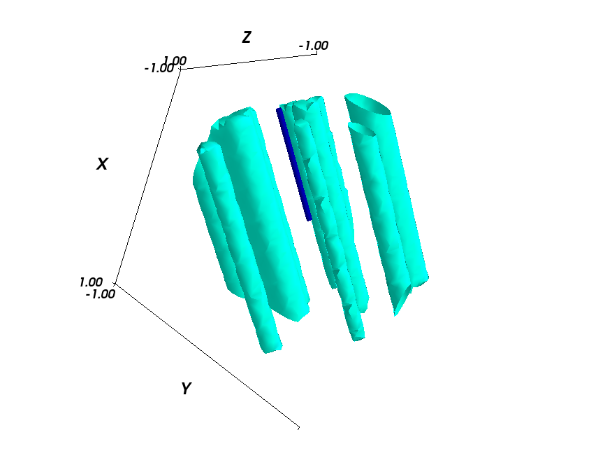

In [7]:
[i1,i2,i3] = np.meshgrid(i,i,i, indexing='ij')
mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))
mlab.contour3d(i1,i2,i3,Vfiber,contours=[0.5,])
mlab.axes()
mlab.plot3d([0,ax0[0,0]],[0,ax0[1,0]],[0,ax0[2,0]], color=(0,0,0.7))

mlab.show(stop=True)

mayavi_show_inline(size=(800,600))

In [8]:
Vplane,_ = make_fiber_volume(ctrx,ctry,rx,4.0*rx, i, 15.0*180/np.pi, 5.0*180/np.pi)

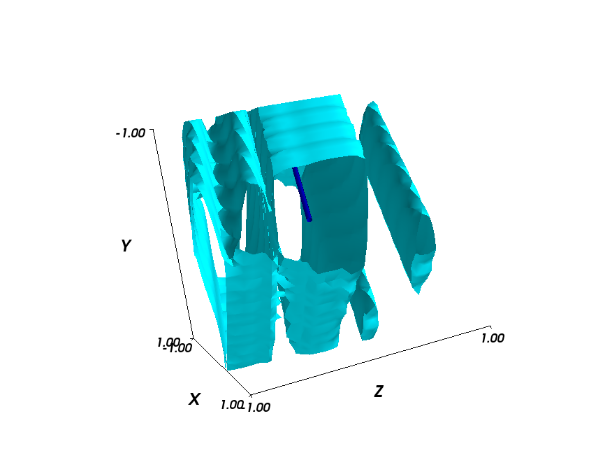

In [9]:
[i1,i2,i3] = np.meshgrid(i,i,i, indexing='ij')
mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))
mlab.contour3d(i1,i2,i3,Vplane,contours=[0.5,])
mlab.axes()
mlab.plot3d([0,ax0[0,0]],[0,ax0[1,0]],[0,ax0[2,0]], color=(0,0,0.7))

mlab.show(stop=True)

mayavi_show_inline(size=(800,600))

In [10]:
vrf,wf,Cf = fibers.fiber_angle(Vfiber, returncorr=True)

a = np.arange(Cf.shape[0]) - Cf.shape[0]/2
[a,b,c] = meshgrid(a,a,a, indexing='ij')

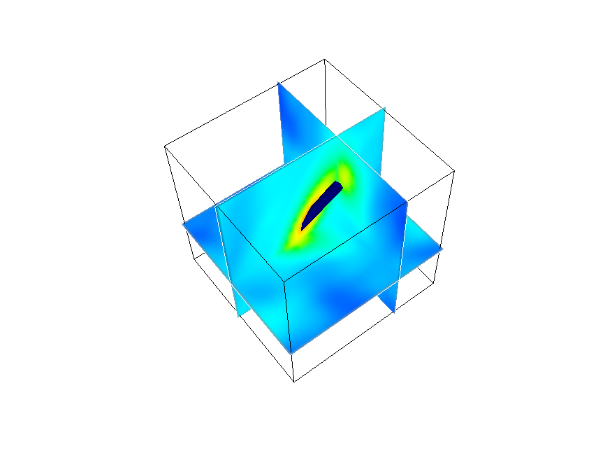

In [11]:
mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))
sf = mlab.pipeline.scalar_field(a,b,c, Cf)

mlab.pipeline.image_plane_widget(sf, plane_orientation='x_axes',
                                slice_index=int(a.shape[0]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='y_axes',
                                slice_index=int(a.shape[1]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='z_axes',
                                slice_index=int(a.shape[2]/2))
mlab.outline()

vec = np.vstack((-vrf[:,0],vrf[:,0]))
mlab.plot3d(vec[:,0]*8,vec[:,1]*8,vec[:,2]*8, color=(0,0,0.7),
           tube_radius=1.0)

mlab.show(stop=True)

mayavi_show_inline(size=(800,600))

In [12]:
vrp,wp,Cp = fibers.fiber_angle(Vplane, returncorr=True)

a = np.arange(Cp.shape[0]) - Cp.shape[0]/2
[a,b,c] = meshgrid(a,a,a, indexing='ij')

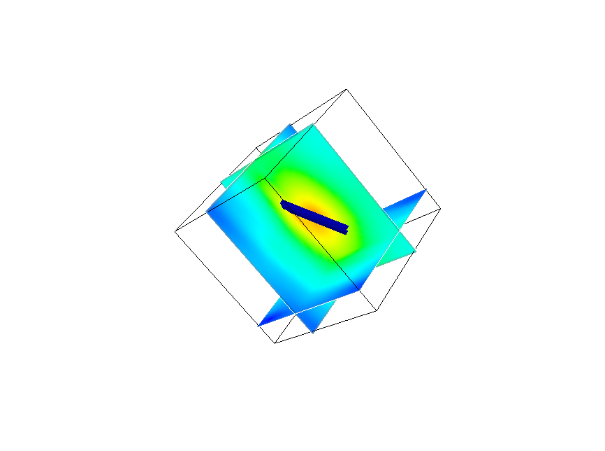

In [13]:
mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))
sf = mlab.pipeline.scalar_field(a,b,c, Cp)

mlab.pipeline.image_plane_widget(sf, plane_orientation='x_axes',
                                slice_index=int(a.shape[0]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='y_axes',
                                slice_index=int(a.shape[1]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='z_axes',
                                slice_index=int(a.shape[2]/2))
mlab.outline()

vec = np.vstack((-vrp[:,0],vrp[:,0]))
mlab.plot3d(vec[:,0]*8,vec[:,1]*8,vec[:,2]*8, color=(0,0,0.7),
           tube_radius=1.0)

mlab.show(stop=True)

mayavi_show_inline(size=(800,600))

In [14]:
print "Fiber: {}".format(np.real(wf))
print "Plane: {}".format(np.real(wp))

Fiber: [-2863.5118424  -8375.71688706 -9302.81155159]
Plane: [-3462.180869   -3856.62731338 -6799.37995292]


In [38]:
angy = np.linspace(0,np.pi,8)
angz = np.linspace(0,2*np.pi,16)
width = [1,1.5,2,2.5,3,4,5,8]

eigvecs = np.zeros((3,3,len(angy),len(angz),len(width)))
truevecs = np.zeros((3,3,len(angy),len(angz),len(width)))
eigvals = np.zeros((3,len(angy),len(angz),len(width)))

x = np.linspace(-1,1,32)

for i,angy1 in enumerate(angy):
    for j,angz1 in enumerate(angz):
        for k,width1 in enumerate(width):
            V,truevec = make_fiber_volume(ctrx,ctry,rx,width1*rx, x, angy1,angz1)
            vr,w = fibers.fiber_angle(V)
            
            truevecs[:,:,i,j,k] = truevec
            eigvals[:,i,j,k] = np.real(w)
            eigvecs[:,:,i,j,k] = np.real(vr)

In [39]:
eigvals.shape

(3, 8, 16, 8)

In [40]:
eigvals[:,0,0,1]

array([ -1.42108547e-12,  -4.34798313e+03,  -8.24570930e+03])

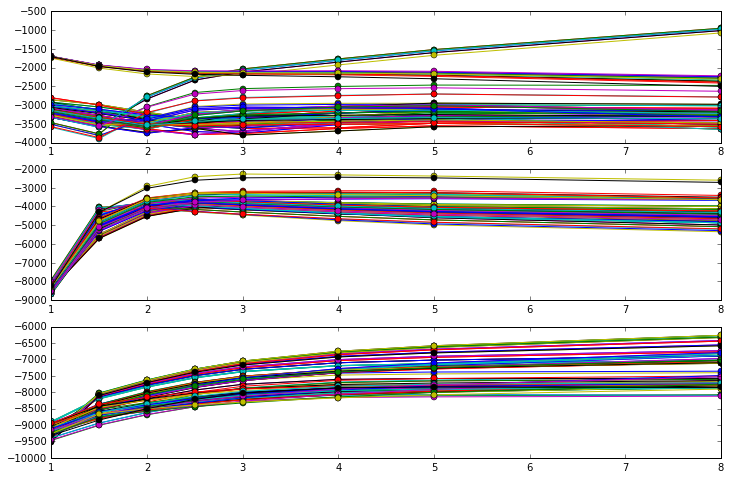

In [48]:
sz = ((len(angy)-1)*len(angz), len(width))

fig,ax = subplots(3,1)
ax[0].plot(width, eigvals[0,1:,:,:].reshape(sz).T,'o-')

ax[1].plot(width, eigvals[1,1:,:,:].reshape(sz).T,'o-')

ax[2].plot(width, eigvals[2,1:,:,:].reshape(sz).T,'o-')

show()

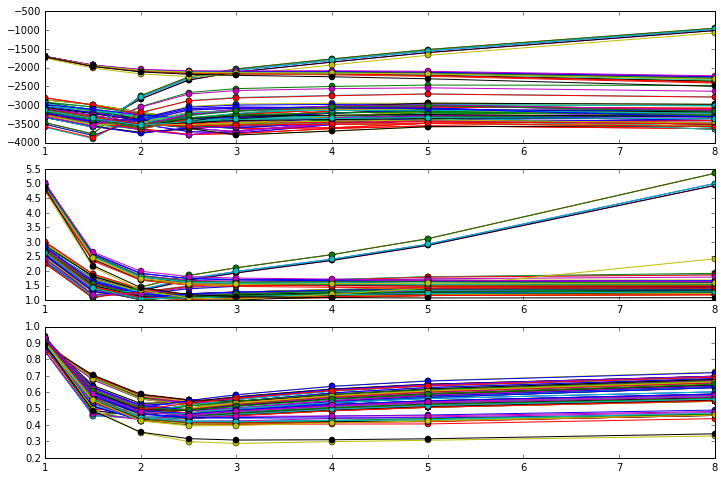

In [49]:
sz = ((len(angy)-1)*len(angz), len(width))

fig,ax = subplots(3,1)
ax[1].plot(width, (eigvals[1,1:,:,:]/eigvals[0,1:,:,:]).reshape(sz).T,'o-')

ax[0].plot(width, eigvals[0,1:,:,:].reshape(sz).T,'o-')

ax[2].plot(width, (eigvals[1,1:,:,:]/eigvals[2,1:,:,:]).reshape(sz).T,'o-')

show()